In [71]:
import pandas as pd
from pandas.tseries.frequencies import to_offset
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from chart_studio.plotly import plot_mpl
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

In [72]:
nvidia = pd.read_csv('./data/Nvidia_history.csv')
amd = pd.read_csv('./data/AMD_stock_price_history.csv')
nvidia_trend = pd.read_csv('./data/Nvidia_google_trend.csv')

In [73]:
nvidia

,Date,Open,High,Low,Close,Adj Close,Volume,Revenue,Future,Market_share
0,1/22/1999,1.750000,1.953125,1.552083,1.640625,1.507891,67867200,NaN,NaN,NaN
1,1/25/1999,1.770833,1.833333,1.640625,1.812500,1.665861,12762000,NaN,NaN,NaN
2,1/26/1999,1.833333,1.869792,1.645833,1.671875,1.536613,8580000,NaN,NaN,NaN
3,1/27/1999,1.677083,1.718750,1.583333,1.666667,1.531826,6109200,NaN,NaN,NaN
4,1/28/1999,1.666667,1.677083,1.651042,1.661458,1.527039,5688000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5624,5/28/2021,620.039978,651.099976,620.039978,649.780029,649.780029,16113400,$5.66B,NaN,80.0
5625,6/1/2021,650.799988,655.530029,636.130005,650.580017,650.580017,11820100,$5.66B,NaN,80.0
5626,6/2/2021,650.090027,676.750000,649.419983,671.130005,671.130005,14854200,$5.66B,NaN,80.0
5627,6/3/2021,668.030029,690.359985,663.320007,678.789978,678.789978,14500200,$5.66B,NaN,80.0


In [74]:
nvidia['daily_change'] = (nvidia.Close - nvidia.Open) / nvidia.Open * 100

In [75]:
nvidia['daily_change'] = nvidia['daily_change'].shift(1)
nvidia.drop(columns=['Volume', 'Open', 'High', 'Low', 'Adj Close'], inplace=True)
nvidia1 = nvidia['Revenue'].str.strip('$').str.extract(r'(\d+\.\d+)([BM]+)')
nvidia['Revenue'] = nvidia1[0].astype(float) * nvidia1[1].map({'B': 1000000000, 'M':1000000})

In [76]:
amd['previous_amd_close_price'] = amd['Close'].shift(1)
amd.drop(columns=['Open', 'High', 'Low', 'Adj Close','Volume', 'Close'], inplace=True)

In [77]:
amd

,Date,previous_amd_close_price
0,3/17/1980,NaN
1,3/18/1980,3.145833
2,3/19/1980,3.031250
3,3/20/1980,3.041667
4,3/21/1980,3.010417
...,...,...
10394,6/7/2021,81.580002
10395,6/8/2021,81.349998
10396,6/9/2021,80.889999
10397,6/10/2021,79.959999


In [78]:
nvidia = nvidia.merge(amd, on='Date', how='left')

In [79]:
nvidia

,Date,Close,Revenue,Future,Market_share,daily_change,previous_amd_close_price
0,1/22/1999,1.640625,NaN,NaN,NaN,NaN,10.500000
1,1/25/1999,1.812500,NaN,NaN,NaN,-6.250000,10.781250
2,1/26/1999,1.671875,NaN,NaN,NaN,2.352960,10.718750
3,1/27/1999,1.666667,NaN,NaN,NaN,-8.806802,11.000000
4,1/28/1999,1.661458,NaN,NaN,NaN,-0.621078,10.625000
...,...,...,...,...,...,...,...
5624,5/28/2021,649.780029,5.660000e+09,NaN,80.0,-1.348743,78.419998
5625,6/1/2021,650.580017,5.660000e+09,NaN,80.0,4.796473,80.080002
5626,6/2/2021,671.130005,5.660000e+09,NaN,80.0,-0.033800,80.809998
5627,6/3/2021,678.789978,5.660000e+09,NaN,80.0,3.236471,81.970001


In [80]:
nvidia_trend

,Month,Nvidia
0,2004-01,96
1,2004-02,80
2,2004-03,88
3,2004-04,84
4,2004-05,79
...,...,...
205,2021-02,37
206,2021-03,33
207,2021-04,33
208,2021-05,33


In [81]:
trend = []
for date in nvidia['Date']:
    month = date.split('/')[0]
    if int(month) < 10:
        month = f'0{month}'
    else:
        month = month
    year = date.split('/')[2]
    year_month = f'{year}-{month}'
    if int(year) < 2004:
        trend.append(0)
    else:
        trend.append(int(nvidia_trend.Nvidia[nvidia_trend.Month == year_month]))

In [82]:
nvidia['trend'] = trend
nvidia['trend'] = nvidia['trend'].astype(int)

In [83]:
nvidia

,Date,Close,Revenue,Future,Market_share,daily_change,previous_amd_close_price,trend
0,1/22/1999,1.640625,NaN,NaN,NaN,NaN,10.500000,0
1,1/25/1999,1.812500,NaN,NaN,NaN,-6.250000,10.781250,0
2,1/26/1999,1.671875,NaN,NaN,NaN,2.352960,10.718750,0
3,1/27/1999,1.666667,NaN,NaN,NaN,-8.806802,11.000000,0
4,1/28/1999,1.661458,NaN,NaN,NaN,-0.621078,10.625000,0
...,...,...,...,...,...,...,...,...
5624,5/28/2021,649.780029,5.660000e+09,NaN,80.0,-1.348743,78.419998,33
5625,6/1/2021,650.580017,5.660000e+09,NaN,80.0,4.796473,80.080002,39
5626,6/2/2021,671.130005,5.660000e+09,NaN,80.0,-0.033800,80.809998,39
5627,6/3/2021,678.789978,5.660000e+09,NaN,80.0,3.236471,81.970001,39


In [84]:
nvidia['Date'] = pd.to_datetime(nvidia['Date'])
nvidia = nvidia[nvidia.Date >= '2017-01-01']
nvidia = nvidia.set_index('Date')

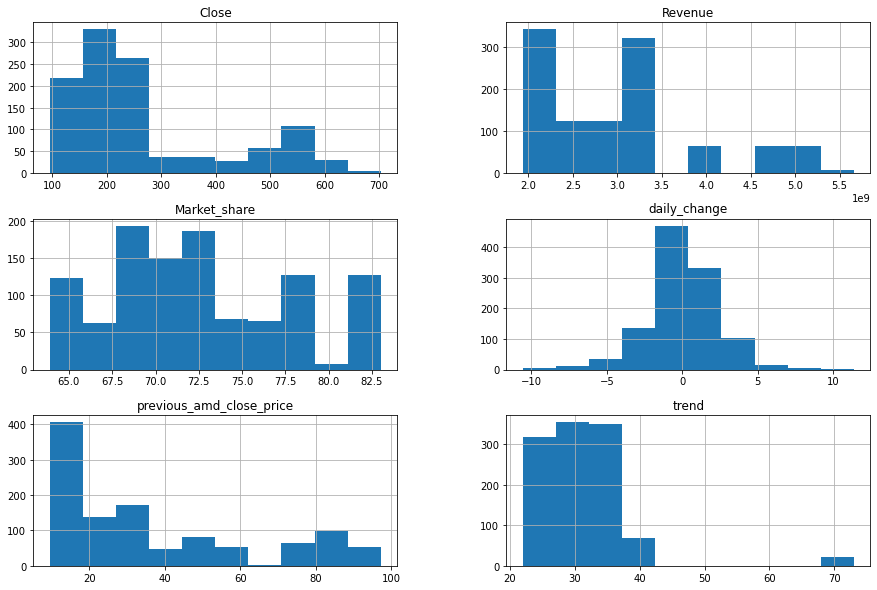

In [85]:
fig, ax = plt.subplots(figsize = (15,10))
nvidia.hist(bins = 10, ax=ax)
fig.savefig('./images/variables_distribution.png')

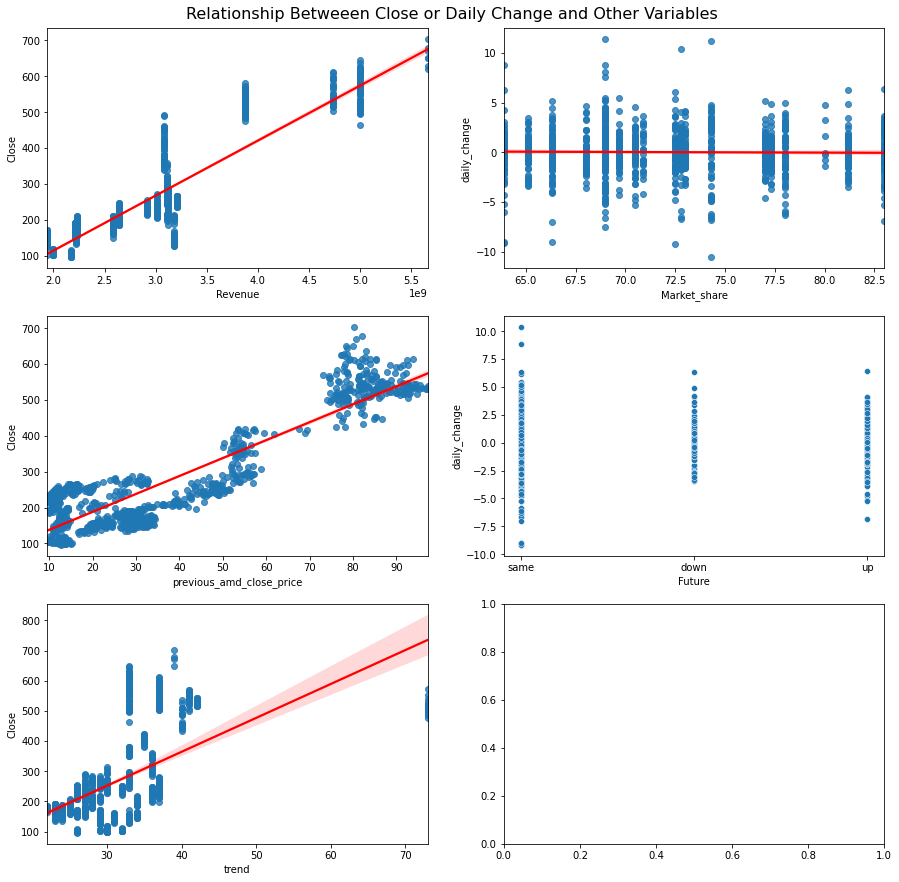

In [86]:
# create regression plots to check the relationship between price and other variables
fig, axes = plt.subplots(3, 2, figsize=(15,15))
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]
ax5 = axes[2][0]
X = nvidia.drop('Close', axis = 1)
y = nvidia['Close']
fig.suptitle('Relationship Betweeen Close or Daily Change and Other Variables', fontsize=16, y=0.9)
sns.regplot(x=X['Revenue'], y=y, line_kws={"color": "red"}, ax=ax1)
sns.regplot(x=X['Market_share'], y=X['daily_change'], line_kws={"color": "red"}, ax=ax2)
sns.regplot(x=X['previous_amd_close_price'], y=y, line_kws={"color": "red"}, ax=ax3)
sns.scatterplot(x=X['Future'], y=X['daily_change'], ax=ax4)
sns.regplot(x=X['trend'], y=y, line_kws={"color": "red"}, ax=ax5)
fig.savefig('./images/close_variables_relationship.png')

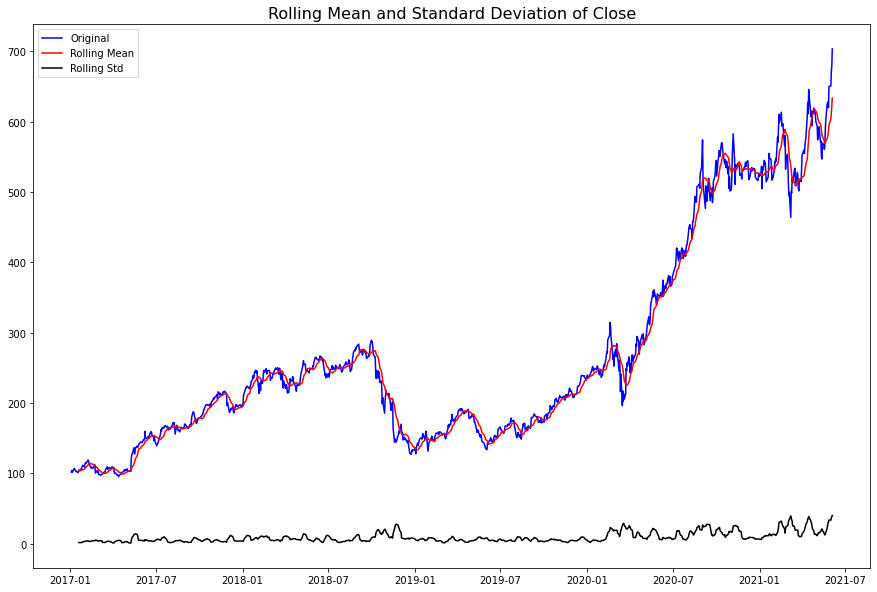

Results of dickey fuller test
Test Statistics                   1.317518
p-value                           0.996705
No. of lags used                 14.000000
Number of observations used    1098.000000
critical value (1%)              -3.436320
critical value (5%)              -2.864176
critical value (10%)             -2.568173
dtype: float64


In [87]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(15,10))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Close', fontsize=16)
    plt.savefig('./images/close_rolling_mean_std.png')
    plt.show()
    
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
    
test_stationarity(nvidia.Close)


<Figure size 432x288 with 0 Axes>

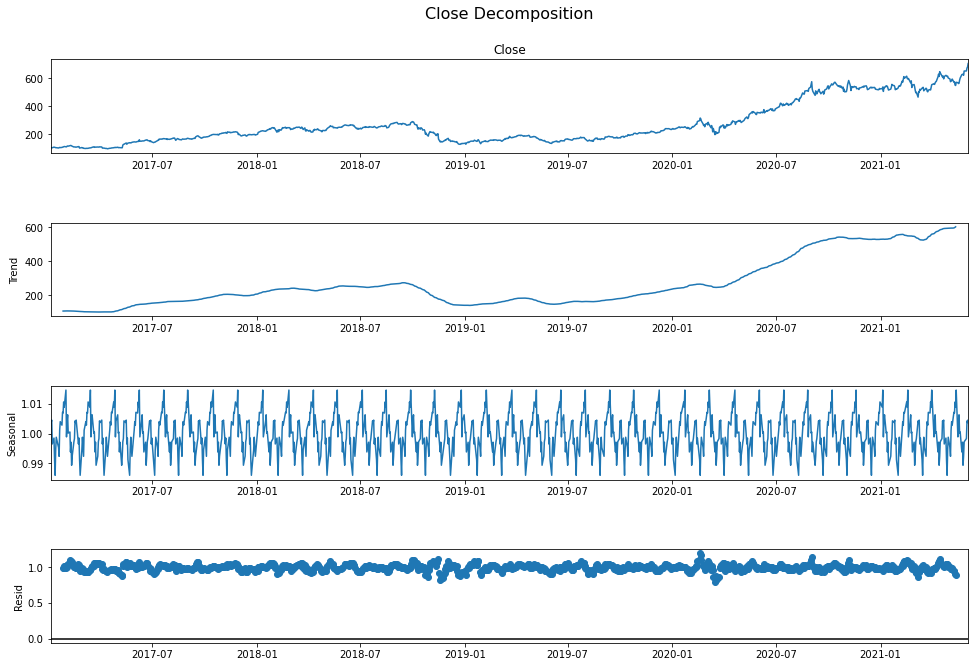

In [88]:
result = seasonal_decompose(nvidia.Close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)
fig.suptitle('Close Decomposition', fontsize=16, x = 0.55)
fig.savefig('./images/close_dcompose.png')

No handles with labels found to put in legend.


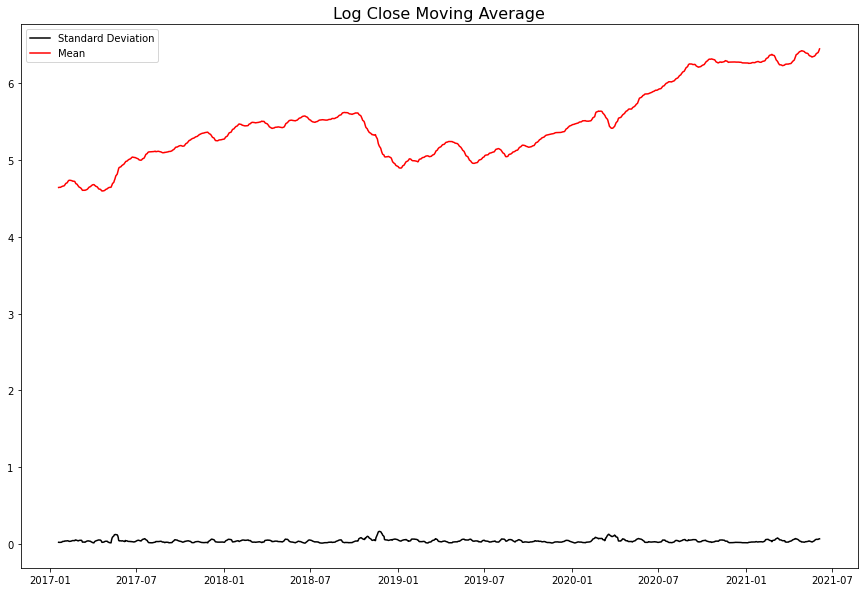

In [89]:
rcParams['figure.figsize'] = 10, 6
nvidia_stock_log = np.log(nvidia.Close)
moving_avg = nvidia_stock_log.rolling(12).mean()
std_dev = nvidia_stock_log.rolling(12).std()
plt.figure(figsize=(15,10))
plt.legend(loc='best')
plt.title('Log Close Moving Average', fontsize=16)
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.savefig('./images/log_close_moving_average.png')
plt.show()

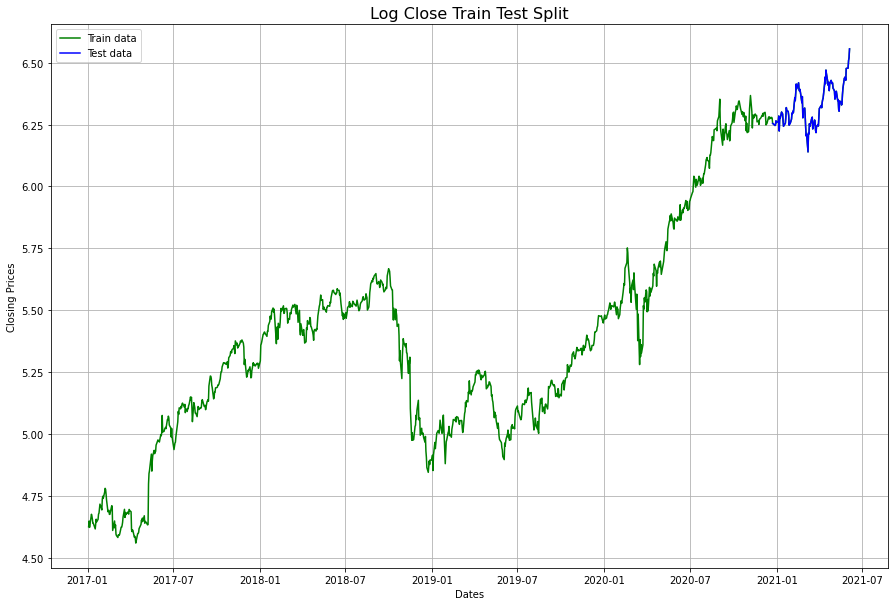

In [90]:
train_data, test_data = nvidia_stock_log[3:int(len(nvidia_stock_log)*0.90)], nvidia_stock_log[int(len(nvidia_stock_log)*0.90):]
plt.figure(figsize=(15,10))
plt.grid(True)
plt.title('Log Close Train Test Split', fontsize=16)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(nvidia_stock_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.savefig('./images/log_close_train_test_split.png')

In [91]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4141.951, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4154.961, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4153.450, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4141.011, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4155.158, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4153.750, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4152.933, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4154.371, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4151.719, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4153.768, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.016 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  998
Model:               SARIMAX(2, 1, 0)   Log Likeliho

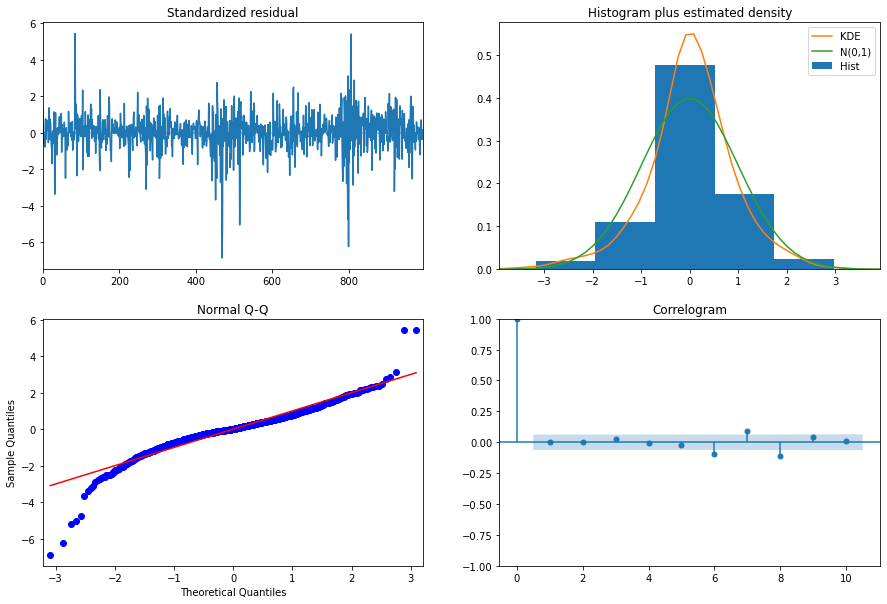

In [92]:
model_autoARIMA.plot_diagnostics(figsize=(15,10))
plt.show()

In [93]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  997
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2081.579
Method:                       css-mle   S.D. of innovations              0.030
Date:                Tue, 15 Jun 2021   AIC                          -4155.158
Time:                        14:01:27   BIC                          -4135.539
Sample:                             1   HQIC                         -4147.700
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.001      1.849      0.064   -9.87e-05       0.003
ar.L1.D.Close    -0.1165      0.032     -3.683      0.000      -0.179      -0.055
ar.L2.D.Close     0.0469      0.032     

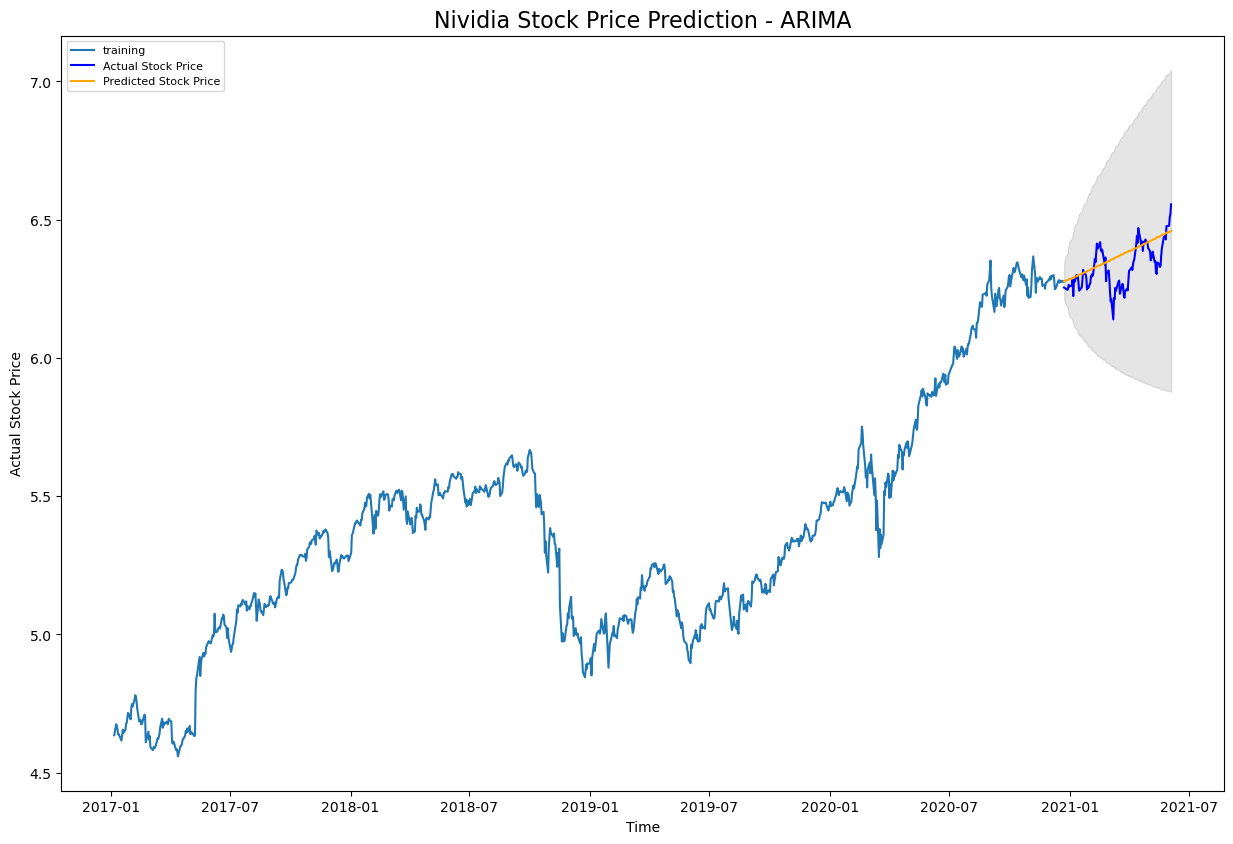

In [94]:
# Forecast
fc, se, conf = fitted.forecast(112, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(15,10), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nividia Stock Price Prediction - ARIMA', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('./images/ARIMA_prediction_result.png')
plt.show()

In [95]:
MSE = np.square(np.subtract(test_data,fc_series)).mean() 
 
RMSE = math.sqrt(MSE)
RMSE

0.07406765243344239

In [96]:
exo_df = nvidia.drop(columns=['Close', 'Future', 'trend', 'Revenue'])
train_exo_data, test_exo_data = exo_df[3:int(len(exo_df)*0.90)], exo_df[int(len(exo_df)*0.90):]

In [97]:
model_autoARIMA_exo = auto_arima(train_data, exogenous=train_exo_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_exo.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4153.797, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4153.462, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4153.089, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4152.061, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4151.844, Time=1.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.705 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  998
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2081.899
Date:                Tue, 15 Jun 2021   AIC                          -4153.797
Time:                        14:01:33   BIC                          -4129.273
Sample:                             0   HQIC                         -4144.475
                                - 998                                  

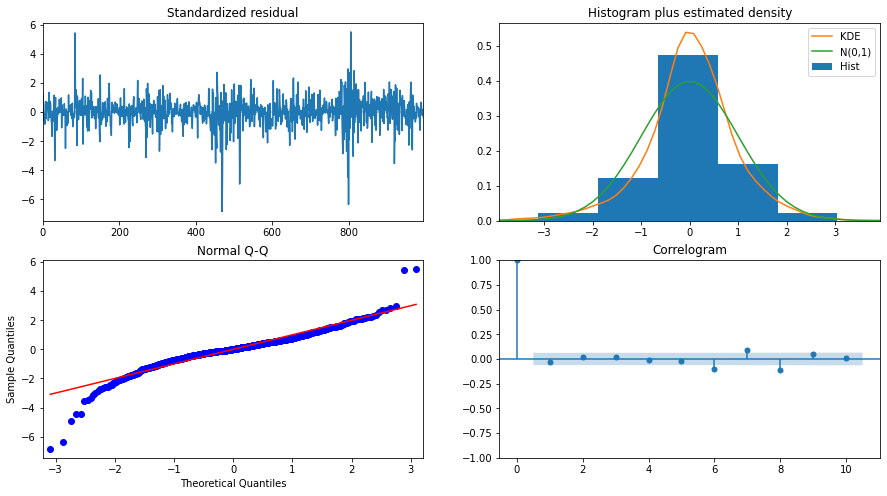

In [98]:
model_autoARIMA_exo.plot_diagnostics(figsize=(15,8))
plt.show()

In [99]:
model2 = ARIMA(train_data, exog=train_exo_data, order=(0, 1, 0))  
fitted = model2.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  997
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2080.321
Method:                           css   S.D. of innovations              0.030
Date:                Tue, 15 Jun 2021   AIC                          -4150.642
Time:                        14:01:44   BIC                          -4126.118
Sample:                             1   HQIC                         -4141.320
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0085      0.015      0.570      0.569      -0.021       0.038
Market_share                -0.0001      0.000     -0.471      0.638      -0.001       0.

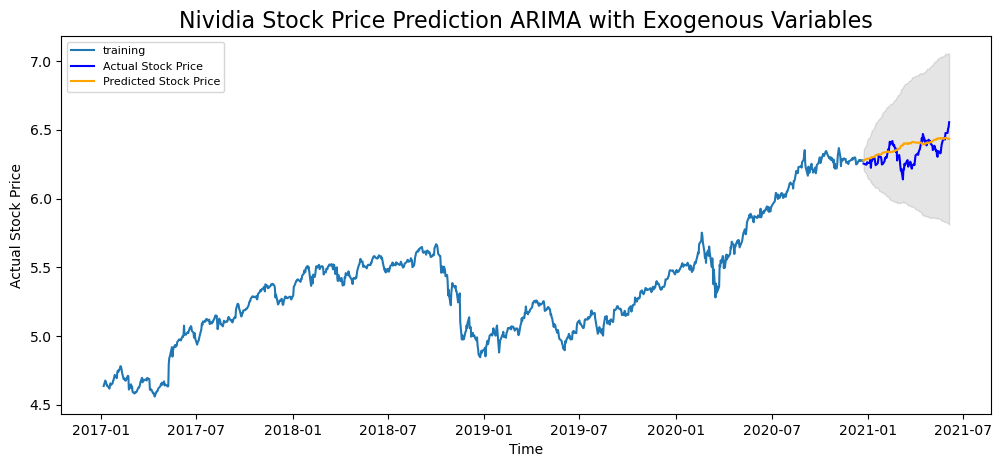

In [100]:
# Forecast
fc, se, conf = fitted.forecast(112, exog=test_exo_data, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nividia Stock Price Prediction ARIMA with Exogenous Variables', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('./images/ARIMA_exo_prediction_result.png')
plt.show()

In [101]:
MSE = np.square(np.subtract(test_data,fc_series)).mean() 
 
RMSE = math.sqrt(MSE)
RMSE

0.08687635479390012

In [519]:
nvidia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1365 entries, 2016-01-04 to 2021-06-04
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Close                         1365 non-null   float64
 1   Revenue                       1240 non-null   float64
 2   Future                        1030 non-null   object 
 3   Market_share                  1365 non-null   float64
 4   daily_change                  1365 non-null   float64
 5   previous_vol_mutiplie_change  1365 non-null   float64
 6   previous_bitcoin_close_price  1365 non-null   float64
 7   trend                         1365 non-null   int32  
dtypes: float64(6), int32(1), object(1)
memory usage: 90.6+ KB


(array([0.00142272, 0.00369906, 0.01308898, 0.05890041, 0.20515553,
        0.13885701, 0.03357608, 0.00341452, 0.00113817, 0.00085363]),
 array([-10.38111455,  -8.20770281,  -6.03429108,  -3.86087934,
         -1.6874676 ,   0.48594414,   2.65935587,   4.83276761,
          7.00617935,   9.17959108,  11.35300282]),
 <BarContainer object of 10 artists>)

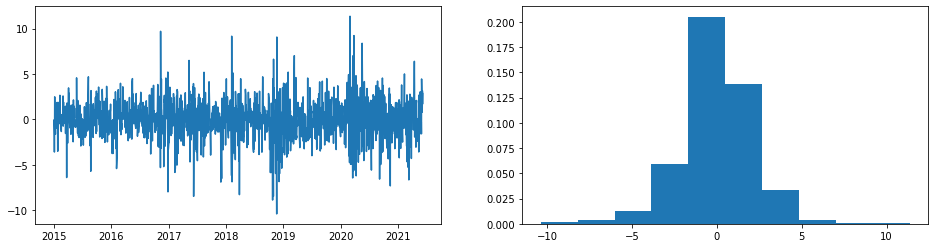

In [584]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

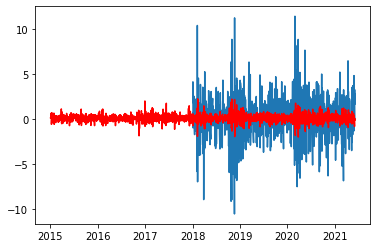

In [585]:
plt.plot(df.daily_change)
plt.plot(result.fittedvalues, color='red')
plt.show()

In [ ]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

In [ ]:
start = datetime.datetime(2020,2,1)
end = datetime.datetime(2020,10,11)

In [ ]:
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [ ]:
Symbols = companies['Symbol'].tolist()

In [ ]:
# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:  
    
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

In [ ]:
stock_final.head()

In [ ]:
https://trends.google.com/trends/explore?q=nvidia&geo=US

In [ ]:
https://docs.github.com/en/github/setting-up-and-managing-your-github-profile/managing-contribution-graphs-on-your-profile/why-are-my-contributions-not-showing-up-on-my-profile